# Mini Project 4

**2025 Introduction to Quantiative Methods in Finance**

**The Erdös Institute**

In the lectures we explored how to delta hedge sold call options, resulting in a trading strategy whose profits are neutral to upward or downward drift in a stock path movements, provided the volatility, or $\sigma$, of the stock remained constant.

For this final mini project explore the impact of a non-constant $\sigma$ on the distribution of profits of hedging. You are also encouraged to explore/research a $\sigma$-hedging strategy and write code that simulates the profit distribution of the $\sigma$-hedging strategy. 

Below is some code you can customize that simulates a stock path whose $\sigma$ is not constant.

You are encouraged to use a different model for sigma then the one provided. You can use stock paths simulated by Heston model? You could use a GARCH model for volatility. The choice is yours and you can do your own research to choose how to model a stock movement. 

In [112]:
#Package Import
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [114]:
#Import functions associated with Black-Scholes Equations

%run functions_black_scholes.py


import types

# List all functions in functions_black_scholes.py
function_list = [name for name, obj in globals().items() if isinstance(obj, types.FunctionType)]
print(function_list[1:])


['import_pandas_safely', 'is_data_frame', 'dataframe_columns', 'dtypes_str', 'dataframe_hash', 'get_dataframes', 'stock_path_custom_sigma', '__nonzero__', 'bs_call', 'bs_put', 'bs_call_delta', 'bs_put_delta', 'bs_gamma', 'bs_vega', 'bs_call_theta', 'bs_put_theta', 'bs_call_rho', 'bs_put_rho']


In [116]:
def stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps):
    '''
    Generation of custom stock paths following Geometeric Brownian motion,
    but log-returns do not have constant volatility.
    
    Each step of the log-returns, there is a 
    1) 50% the volatility is .2
    2) 30% chance the volatility is .3
    3) 20% chance the volatility is .45
    
    Inputs:
    S0 (float): initial stock value
    t (float): time interval of stock path movements in years
    r (float): risk-free interest rate
    mu (float): drift of log-returns
    n_paths (int): number of stock paths
    n_steps (float): number of steps in each stock path
    
    Returns:
    
    Simuatled stock paths
    '''
    
    #Noise in volatility
    noise = np.random.normal(0,1,size = (n_paths, n_steps))
    
    #Custom sigma that is not constant
    sigma = np.random.choice([.2,.3,.45], p = [.5, .3, .2], size = (n_paths, n_steps))
    
    #Time increment between each step
    dt = t/n_steps
    
    #log-returns between each step
    increments = (mu + r - .5*sigma**2)*dt + sigma*np.sqrt(dt)*noise
    
    #Cumulative log-returns at each step
    log_returns = np.cumsum(increments, axis = 1)
    
    
    #paths
    paths = S0*np.exp(log_returns)
    
    
    #Adjoint initial value S0 at start of each simulated path
    paths = np.insert(paths, 0, S0, axis = 1)
    
    
    return paths
    
    

simulated_paths.shape: (10000, 253)


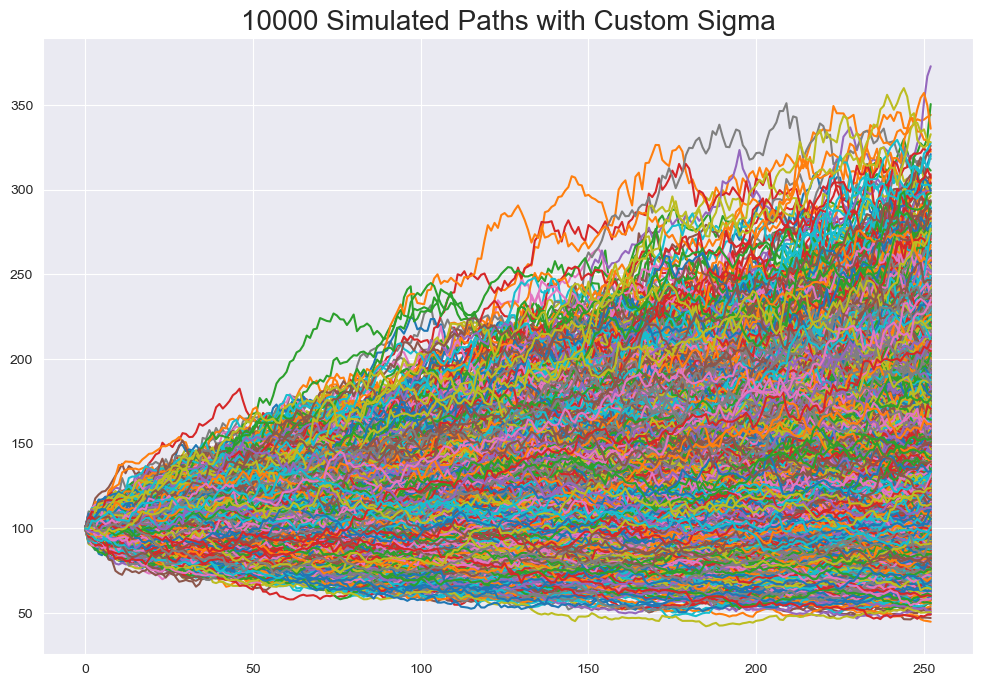

In [118]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
K = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 10000
n_steps = 252
simulated_paths = stock_path_custom_sigma(S0, t, r, mu, n_paths, n_steps)


print("simulated_paths.shape:", simulated_paths.shape)
    


plt.figure(figsize = (12,8))

for path in simulated_paths:
    plt.plot(path)
    
plt.title(f'{n_paths} Simulated Paths with Custom Sigma', size = 20)


plt.show()

mean P&L : -0.5747416990443232
std  P&L : 0.8114349266368449


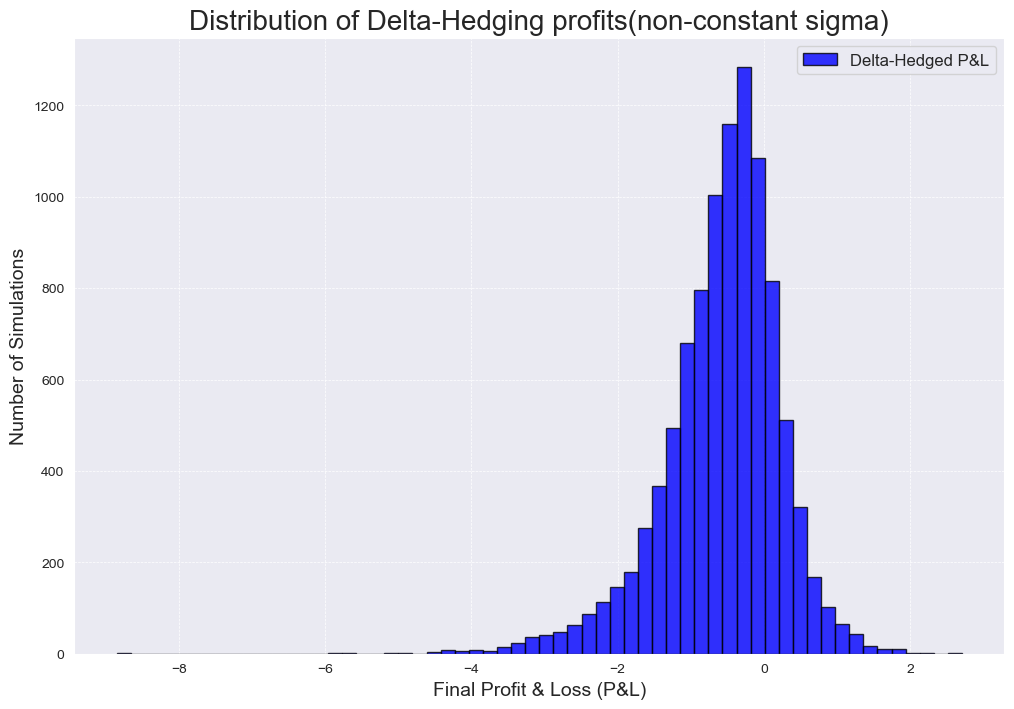

In [119]:
#5 Simulated paths of daily steps over 1-year period and plot

S0 = 100
K = 100
t = 1
r = 0.039
mu = 0.275
n_paths = 10000
n_steps = 252

sigma = 0.28 #Expected sigma value with given possible values of sigma

dt = t/n_steps
delta_hedge = []

for i in range(n_paths):
    simulated_path = simulated_paths[i]


    bs_price = bs_call(S0,K,sigma,t,r)

    delta = bs_call_delta(S0, K, sigma, t, r)
    shares = delta
    cash = bs_price - (shares*S0)

    for j in range(1, n_steps + 1):
        cash *= np.exp(r*dt)
        tte = t - j*dt
        S_t = simulated_path[j]
        if tte > 0:
            new_delta = bs_call_delta(S_t, K, sigma, tte, r)
            tradable_shares = new_delta - shares
            cash -= tradable_shares * S_t
            shares = new_delta

    final_payoff = max(0, simulated_path[-1] - K)
    cash += shares*simulated_path[-1] - final_payoff
    delta_hedge.append(cash)


# Plotting the graph of calculated P&L of the simulated paths

plt.figure(figsize= (12, 8))
plt.hist(delta_hedge, bins = 60, alpha = 0.8, label = "Delta-Hedged P&L", color = "blue", edgecolor = "black")
plt.title("Distribution of Delta-Hedging profits(non-constant sigma)", fontsize = 20)
plt.xlabel('Final Profit & Loss (P&L)', fontsize=14)
plt.ylabel('Number of Simulations', fontsize=14)
plt.legend(fontsize=12)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

mean_delta = np.mean(delta_hedge)
std_delta = np.std(delta_hedge)

print(f"mean P&L : {mean_delta}")
print(f"std  P&L : {std_delta}")

From the graph we can observe that the average profit is around $0$ with the delta hedging, which is consistent with the $\Delta$ we calculated using Black-Scholes model which gives us risk-neutral pricing.